In [204]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import decoupler as dc
import seaborn as sns
from matplotlib_venn import venn2

In [205]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('/Users/johnsmith/Desktop/Senior Design Stuff/tcga.brca.rnaseq.unstranded.raw.counts.matrix-2.txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('/Users/johnsmith/Desktop/Senior Design Stuff/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('/Users/johnsmith/Desktop/Senior Design Stuff/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')

In [281]:
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]

# Keep both protein coding and lncRNA columns
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
# lncRNA_cols = [col for col in gene_columns if 'lncRNA' in col]

# Combine the columns to keep
final_columns = columns_to_keep + protein_coding_cols
rnaseq_df_filt = rnaseq_df[final_columns]

In [282]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df_filt['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))
#common_samples


Number of common samples: 864


In [283]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df[brca_df.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (929, 60663)
hrd_df_common: (864, 5)
brca_df_common: (864, 33)


In [284]:
#merge metadata

metadata = pd.merge(hrd_df_common, brca_df_common, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata

(864, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000e+00,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,4.185667e-02,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,1.203678e-01,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,6.046707e-01,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,4.040409e-02,0,0,0,0,0,LumA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A6VR,4,4,5,13,0,0,0,NaN,0,0,...,0.246553,0.312770,8.560770e-08,0,0,0,0,0,LumA,0
TCGA-PE-A5DC,13,20,16,49,0,0,0,0,NaN,0,...,0.379172,0.336629,1.521539e-01,0,Bi-allelic-inactivation,0,0,YES,LumA,0
TCGA-PE-A5DD,7,6,9,22,0,0,0,0,NaN,0,...,0.000000,0.591578,3.869432e-01,0,0,0,0,0,LumA,0


In [285]:

# Start with the original dataframe
metadata_filtered = metadata.copy()

# Drop rows where event.BRCA1 is '1'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
metadata_filtered = metadata_filtered[metadata_filtered['event.PALB2'] != '2']

print (metadata_filtered.shape)
print(metadata_filtered.columns)
metadata_filtered.head()

metadata = metadata_filtered
metadata['HRD_status_base'] = ['HRD' if x >= 42 else 'HR' for x in metadata['HRD-sum']]

(857, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


In [286]:
#metadata[]

In [287]:
def softLabel(x, median, HRD_thresh, HRP_thresh):
    adjustment = 2 * ((((HRD_thresh - x) / (HRD_thresh - HRP_thresh)) - 0.5) ** 2) + 0.5
    if median <= x < HRD_thresh:
        return adjustment
    elif HRP_thresh <= x < median:
        return 1 - adjustment
    else:
        return -1


In [288]:
medians = metadata.groupby(["event.PAM50"])["HRD-sum"].median().reset_index() 
medians_pivot = medians.set_index('event.PAM50').T
medians_pivot

event.PAM50,Basal,Her2,LumA,LumB
HRD-sum,55.0,35.0,13.0,31.0


In [322]:
for sub in medians_pivot.columns.tolist():
    metadata['HRD_adjust'] = ['HRD' if x >= 50 else 'HRP' if x < 10 else 'HRD ambiguous' if medians_pivot.loc['HRD-sum',sub] <= x < 50 else 'HRP ambiguous' if 10 <= x < medians_pivot.loc['HRD-sum',sub] else 'None' for x in metadata['HRD-sum']]
    metadata['soft prob'] = metadata['HRD-sum'].apply(lambda x: softLabel(x, medians_pivot.loc['HRD-sum',sub], 50, 10))

In [ ]:
#metadata

In [323]:
metadata[['HRD-sum', 'HRD_status_base', 'HRD_adjust', 'soft prob']]

# Define conditions and choices
conditions = [
    (metadata['soft prob'] == -1) & (metadata['HRD_adjust'] == 'HRP'),
    (metadata['soft prob'] == -1) & (metadata['HRD_adjust'] == 'HRD')
]

choices = [0, 1]

# Update the 'soft prob dist' column
metadata['soft prob'] = np.select(conditions, choices, default=metadata['soft prob'])

In [324]:
metadata[metadata['soft prob'] == -1]

,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC,HRD_status_base,HRD_adjust,soft prob
sample,,,,,,,,,,,,,,,,,,,,,


In [325]:
#test = metadata[metadata['soft prob'] != -1 & metadata['HRD-sum'] != 50]
px.scatter(metadata[metadata['soft prob'] != -1], x = 'HRD-sum', y= 'soft prob', title = 'Soft labeling probability mapped to HRD-sum', color = 'HRD_adjust')

In [326]:
metadata[['event.PAM50', 'event.TNBC']]

,event.PAM50,event.TNBC
sample,,
TCGA-A1-A0SB,NaN,0
TCGA-A1-A0SD,LumA,0
TCGA-A1-A0SE,LumA,0
TCGA-A1-A0SF,LumA,0
TCGA-A1-A0SG,LumA,0
...,...,...
TCGA-OL-A6VR,LumA,0
TCGA-PE-A5DC,LumA,0
TCGA-PE-A5DD,LumA,0


In [327]:
metadata_soft = metadata.reset_index()
metadata_soft_filt = metadata_soft[['sample', 'soft prob']]
metadata_soft_filt.rename(columns = {"sample":"Case ID"}, inplace=True)
metadata_soft_filt

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_68610/4237309595.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Case ID,soft prob
0,TCGA-A1-A0SB,0.00000
1,TCGA-A1-A0SD,0.48875
2,TCGA-A1-A0SE,0.13875
3,TCGA-A1-A0SF,0.48000
4,TCGA-A1-A0SG,0.00000
...,...,...
852,TCGA-OL-A6VR,0.13875
853,TCGA-PE-A5DC,0.95125
854,TCGA-PE-A5DD,0.42000
855,TCGA-PE-A5DE,0.50500


In [328]:
top_deseq_genes = pd.read_csv("/Users/johnsmith/Desktop/Senior Design Stuff/Multiscale_HRD_Classifier/top_deseq_genes.tsv", sep = '\t')

In [238]:
top_deseq_genes

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000163975.12|MELTF|protein_coding,4.223192,2.197306,0.122265,17.971713,3.245360e-72,6.764303e-68
1,ENSG00000115163.15|CENPA|protein_coding,4.405742,1.489792,0.087457,17.034557,4.551744e-65,4.743600e-61
2,ENSG00000107937.19|GTPBP4|protein_coding,13.539092,0.820738,0.048266,17.004525,7.601871e-65,5.281526e-61
3,ENSG00000136943.11|CTSV|protein_coding,2.170985,1.952020,0.120999,16.132468,1.508699e-58,7.861454e-55
4,ENSG00000140545.15|MFGE8|protein_coding,31.920965,1.701760,0.106421,15.990769,1.481895e-57,6.177426e-54
...,...,...,...,...,...,...,...
1964,ENSG00000288398.1|AL109627.1|lncRNA,3.281440,-0.503236,0.070646,-7.123355,1.053312e-12,9.136156e-12
1965,ENSG00000120733.14|KDM3B|protein_coding,16.828186,-0.267694,0.037594,-7.120650,1.074193e-12,9.313400e-12
1966,ENSG00000152217.20|SETBP1|protein_coding,2.345679,-0.735301,0.103282,-7.119365,1.084256e-12,9.392833e-12
1967,ENSG00000101290.14|CDS2|protein_coding,8.144601,-0.358923,0.050443,-7.115361,1.116206e-12,9.661574e-12


In [329]:
real_merged_df = rnaseq_df_filt.merge(metadata_soft_filt, on='Case ID', how  = 'inner')
real_real_merged_df = real_merged_df.drop_duplicates(subset = 'Case ID')

In [333]:
#real_merged_df

,Case ID,Sample ID,Sample Type,soft prob
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.00000
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,0.50500
2,TCGA-E9-A1RH,TCGA-E9-A1RH-11A,Solid Tissue Normal,1.00000
3,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,0.04875
4,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.00000
...,...,...,...,...
916,TCGA-BH-A0AU,TCGA-BH-A0AU-01A,Primary Tumor,0.52000
917,TCGA-A8-A09G,TCGA-A8-A09G-01A,Primary Tumor,0.37500
918,TCGA-E2-A14X,TCGA-E2-A14X-01A,Primary Tumor,0.32000
919,TCGA-HN-A2OB,TCGA-HN-A2OB-01A,Primary Tumor,0.00000


In [330]:
genes_to_keep = top_deseq_genes['Unnamed: 0'].tolist()
real_real_merged_df_filt = real_merged_df[['soft prob']+[col for col in real_merged_df.columns if col in genes_to_keep]]

In [312]:
#real_real_merged_df_filt.drop(columns=['soft prob']).select_dtypes(include=[float, int]).values

In [331]:
final_merge = real_real_merged_df.reset_index(drop=True)

In [332]:
final_merge

,Case ID,Sample ID,Sample Type,soft prob
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.00000
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,0.50500
2,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,0.04875
3,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.00000
4,TCGA-BH-A18F,TCGA-BH-A18F-01A,Primary Tumor,0.00000
...,...,...,...,...
852,TCGA-AO-A0JE,TCGA-AO-A0JE-01A,Primary Tumor,0.53125
853,TCGA-A8-A09G,TCGA-A8-A09G-01A,Primary Tumor,0.37500
854,TCGA-E2-A14X,TCGA-E2-A14X-01A,Primary Tumor,0.32000
855,TCGA-HN-A2OB,TCGA-HN-A2OB-01A,Primary Tumor,0.00000


In [319]:
final_merge[final_merge['soft prob'] == -1]

,Case ID,Sample ID,Sample Type,soft prob
269,TCGA-E9-A1ND,TCGA-E9-A1ND-11A,Solid Tissue Normal,-1.0
283,TCGA-E9-A1RF,TCGA-E9-A1RF-11A,Solid Tissue Normal,-1.0
318,TCGA-AO-A03O,TCGA-AO-A03O-01A,Primary Tumor,-1.0
367,TCGA-AC-A2BK,TCGA-AC-A2BK-01A,Primary Tumor,-1.0
478,TCGA-A7-A26G,TCGA-A7-A26G-01A,Primary Tumor,-1.0
633,TCGA-A8-A07U,TCGA-A8-A07U-01A,Primary Tumor,-1.0


In [264]:
# Define y (target) and X (predictors)
y = real_real_merged_df_filt["soft prob"].dropna().values
X = real_real_merged_df_filt.drop(columns=['soft prob']).select_dtypes(include=[float, int]).values
feature_names = real_real_merged_df_filt.columns

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

ValueError: Found array with 0 feature(s) (shape=(736, 0)) while a minimum of 1 is required by LinearRegression.

In [171]:
#real_merged_df

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Filter the dataframe for training and testing based on `soft prob` values
train_data = real_merged_df_filt[real_merged_df_filt["soft prob"].isin([0, 1])]
test_data = real_merged_df_filt[(real_merged_df_filt["soft prob"] > 0) & (real_merged_df_filt["soft prob"] < 1)]

# Define y (target) and X (predictors) for training and testing
y_train = train_data["soft prob"].values
X_train = train_data.drop(columns=['soft prob']).select_dtypes(include=[float, int]).values

y_test = test_data["soft prob"].values
X_test = test_data.drop(columns=['soft prob']).select_dtypes(include=[float, int]).values

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)


Mean Squared Error (MSE): 0.42128320284879056
R-squared (R²): -9.428058034647304


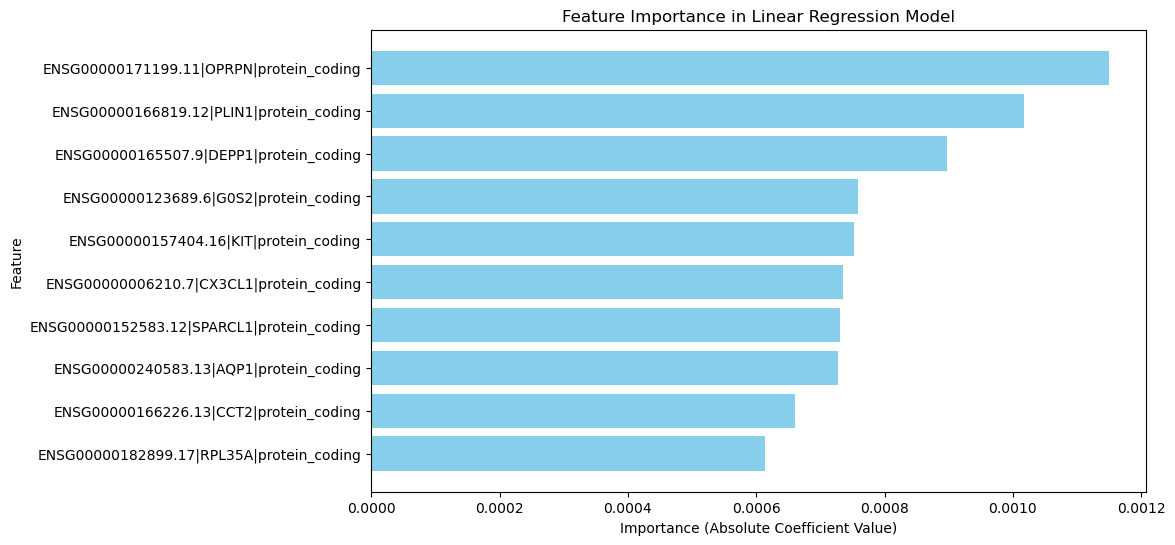

In [166]:
# Define y (target) and X (predictors)
y = real_merged_df["soft prob"].dropna().values
X = real_merged_df.drop(columns=['soft prob']).select_dtypes(include=[float, int]).values
feature_names = real_merged_df.drop(columns=['soft prob']).select_dtypes(include=[float, int]).columns  # Store column names for plotting

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Get feature importance (absolute values of the coefficients)
coefficients = model.coef_
importance = np.abs(coefficients)

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(10)
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()

In [97]:
importance_df.head()

,Feature,Importance
659,ENSG00000144043.12|TEX261|protein_coding,0.024342
1064,ENSG00000188938.17|FAM120AOS|protein_coding,0.022225
1003,ENSG00000182175.14|RGMA|protein_coding,0.022225
278,ENSG00000109861.17|CTSC|protein_coding,0.022206
973,ENSG00000177946.6|CENPBD1|protein_coding,0.021977
...,...,...
765,ENSG00000159763.4|PIP|protein_coding,0.000007
724,ENSG00000153002.12|CPB1|protein_coding,0.000005
208,ENSG00000102316.17|MAGED2|protein_coding,0.000005
443,ENSG00000124935.4|SCGB1D2|protein_coding,0.000005


In [136]:
dc.show_resources()


['Adhesome',
 'Almen2009',
 'Baccin2019',
 'CORUM_Funcat',
 'CORUM_GO',
 'CSPA',
 'CSPA_celltype',
 'CancerDrugsDB',
 'CancerGeneCensus',
 'CancerSEA',
 'CellCall',
 'CellCellInteractions',
 'CellChatDB',
 'CellChatDB_complex',
 'CellPhoneDB',
 'CellPhoneDB_complex',
 'CellTalkDB',
 'CellTypist',
 'Cellinker',
 'Cellinker_complex',
 'ComPPI',
 'CytoSig',
 'DGIdb',
 'DisGeNet',
 'EMBRACE',
 'Exocarta',
 'GO_Intercell',
 'GPCRdb',
 'Guide2Pharma',
 'HGNC',
 'HPA_secretome',
 'HPA_subcellular',
 'HPA_tissue',
 'HPMR',
 'HumanCellMap',
 'ICELLNET',
 'ICELLNET_complex',
 'IntOGen',
 'Integrins',
 'InterPro',
 'KEGG-PC',
 'Kirouac2010',
 'LOCATE',
 'LRdb',
 'Lambert2018',
 'MCAM',
 'MSigDB',
 'Matrisome',
 'MatrixDB',
 'Membranome',
 'NetPath',
 'OPM',
 'PROGENy',
 'PanglaoDB',
 'Phobius',
 'Phosphatome',
 'Ramilowski2015',
 'Ramilowski_location',
 'SIGNOR',
 'SignaLink_function',
 'SignaLink_pathway',
 'Surfaceome',
 'TCDB',
 'TFcensus',
 'TopDB',
 'UniProt_family',
 'UniProt_keyword',
 'Un

In [142]:
background_set = dc.get_resource('MSigDB')
background_set.drop_duplicates(inplace=True)

In [143]:
background_set

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [140]:
gene_list = importance_df['Feature'].str.split('|').str[1].to_list()

In [144]:
ORA_df = dc.get_ora_df(
    df = gene_list,
    net = background_set,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

Running ora on df with 1147 targets for 33552 sources with 20000 background features.


In [145]:
ORA_df['-log 10 p-value'] = np.log10(ORA_df['p-value'])*-1
test_pval_filt = ORA_df[ORA_df['p-value'] < 0.05]

test_pval_filt = test_pval_filt.sort_values(by=['-log 10 p-value'])
test_pval_filt.tail(10)

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,-log 10 p-value
22289,MODULE_54,262,0.488550,3.585711e-88,9.577435e-85,9.477652,1908.330167,AIF1L;ANLN;ANP32E;APOBEC3B;ARHGAP11A;ASPM;ATAD...,87.445425
14532,HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_NK_CELL,668,0.296407,3.367963e-89,9.995367e-86,6.045777,1231.620158,ACTL6A;ALYREF;ANLN;APOBEC3B;ARHGAP11A;ASPM;ATA...,88.472633
19631,MEBARKI_HCC_PROGENITOR_FZD8CRD_UP,541,0.334566,4.002774e-91,1.336426e-87,6.748511,1404.690882,ADGRB2;ANLN;ARHGAP11A;ASPM;ATAD2;AUNIP;AURKA;A...,90.397639
14546,HE_LIM_SUN_FETAL_LUNG_C5_PRO_B_CELL,459,0.366013,1.808744e-91,6.901650e-88,7.315901,1528.603548,AARS1;ADGRG1;ANLN;ARHGAP11A;ASPM;ATAD2;AURKA;A...,90.742623
24800,SMID_BREAST_CANCER_BASAL_UP,655,0.303817,7.521983e-92,3.348536e-88,6.207444,1302.445945,ACTG2;AGBL5;AMD1;ANP32E;APOBEC3B;ASPM;ATAD2;AT...,91.123668
1494,DUTERTRE_ESTRADIOL_RESPONSE_24HR_UP,322,0.450311,1.010293e-93,5.396986e-90,8.856067,1896.351120,ANLN;ARHGAP11A;ASPM;ATAD2;AURKA;AURKB;BIRC5;BL...,92.995553
14545,HE_LIM_SUN_FETAL_LUNG_C5_LARGE_PRE_B_CELL,1341,0.215511,9.315059e-95,6.220131e-91,4.690483,1015.555073,AARS1;ACTL6A;AFG3L2;AGO2;ALYREF;ANLN;ANP32E;AP...,94.030814
2259,GOBERT_OLIGODENDROCYTE_DIFFERENTIATION_UP,572,0.340909,3.634924e-100,3.236294e-96,6.965392,1594.851309,AARS1;AKR1E2;ALAD;ANP32E;ARHGAP11A;ASPM;ATAD2;...,99.439505
1700,FISCHER_DREAM_TARGETS,945,0.264550,8.473336e-102,1.131614e-97,5.625124,1309.116820,AARS1;ACTL6A;AMD1;ANKRA2;ANLN;ANP32E;APOBEC3B;...,101.071946
1665,FARMER_BREAST_CANCER_BASAL_VS_LULMINAL,326,0.475460,8.078663e-105,2.157811e-100,9.441052,2262.852229,ABAT;ACADSB;ACTL6A;ALDH6A1;AMD1;ANXA9;APBB2;AR...,104.092661


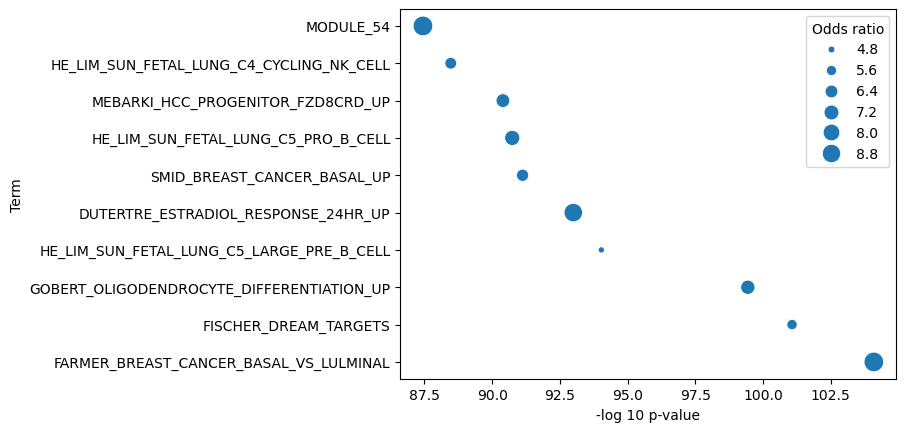

In [146]:
plot = sns.scatterplot(
    data=test_pval_filt.tail(10), x="-log 10 p-value", y="Term",  size="Odds ratio",
    sizes=(20, 200)
)